In [105]:
import numpy as np
import pandas as pd

from src.utils.path_converter import path_converter

In [106]:
items_df = pd.read_csv(path_converter("/data/features/demand_type.csv"))
df = pd.read_csv(
    filepath_or_buffer=path_converter("/data/raw/sales_train.csv"), parse_dates=["date"]
)

In [107]:
# # Load dữ liệu
# df2 = pd.read_csv(path_converter("/data/raw/online_retail.csv"), encoding="latin1")

# # Chuyển InvoiceDate sang datetime
# df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"], dayfirst=True)

# # Thêm date_block_num theo tháng
# df2["date_block_num"] = (df2["InvoiceDate"].dt.year - 2010) * 12 + (
#     df2["InvoiceDate"].dt.month - 1
# )

# # Nếu chỉ có 1 shop: tạo shop_id = 0
# df2["shop_id"] = 0

# # Map StockCode thành item_id
# df2["item_id"] = df2["StockCode"].astype("category").cat.codes

# # Group theo ngày + item + shop
# df2_new = (
#     df2.groupby(["InvoiceDate", "date_block_num", "shop_id", "item_id"])
#     .agg(
#         {"UnitPrice": "mean", "Quantity": "sum"}  # trung bình nếu nhiều đơn trong ngày
#     )
#     .reset_index()
# )

# # Đổi tên cột và chuyển date về format DD.MM.YYYY
# df2_new.rename(
#     columns={
#         "InvoiceDate": "date",
#         "UnitPrice": "item_price",
#         "Quantity": "item_cnt_day",
#     },
#     inplace=True,
# )

# df2_new["date"] = df2_new["date"].dt.strftime("%d.%m.%Y")

# df = df2_new.copy()

# print(df2_new.head())

In [108]:
smooth_items = items_df[items_df["demand_type"] == 1]["item_id"].tolist()
intermittent_items = items_df[items_df["demand_type"] == 2]["item_id"].tolist()
lumpy_items = items_df[items_df["demand_type"] == 0]["item_id"].tolist()

In [109]:
daily_series_df = (
    df.groupby(["item_id", "date"])["item_cnt_day"].sum().unstack(fill_value=0)
)

In [110]:
def sba(y, alpha=0.1, n_forecast=7):
    """
    Syntetos-Boylan Approximation (SBA) for intermittent demand
    """
    y = np.array(y)
    n = len(y)
    
    # Croston forecast
    demand_hat, interval_hat = 0, 0
    last_demand, last_interval = 0, 1
    forecast_val = 0
    for t in range(n):
        if y[t] > 0:
            if last_demand == 0:
                demand_hat = y[t]
                interval_hat = last_interval
            else:
                demand_hat = alpha * y[t] + (1-alpha) * demand_hat
                interval_hat = alpha * last_interval + (1-alpha) * interval_hat
            forecast_val = demand_hat / interval_hat
            last_demand = y[t]
            last_interval = 1
        else:
            last_interval += 1
    
    # SBA correction factor: multiply Croston by 1 - alpha/2
    forecast_sba = forecast_val * (1 - alpha/2)
    
    return np.array([forecast_sba]*n_forecast)


In [115]:
def moving_average(y, window=7, n_forecast=7):
    ma = y[-window:].mean()
    print(ma)
    return np.array([ma]*n_forecast)

from sklearn.metrics import mean_absolute_error

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.abs(np.diff(y_train)).sum() / (n-1)
    return np.abs(y_true - y_pred).mean() / d

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Item 3657.0 Metrics:
  MA   -> MAE: 0.071, MASE: 2.022
  SBA  -> MAE: 0.084, MASE: 2.381



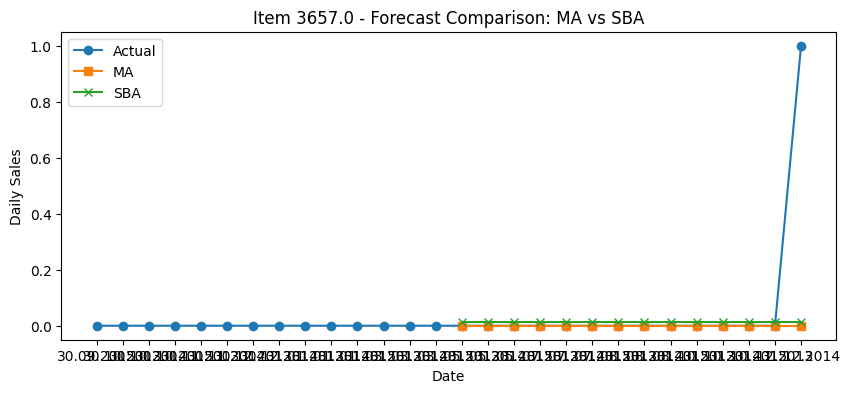

0.14285714285714285
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714]
Item 259.0 Metrics:
  MA   -> MAE: 0.194, MASE: 0.721
  SBA  -> MAE: 0.226, MASE: 0.840



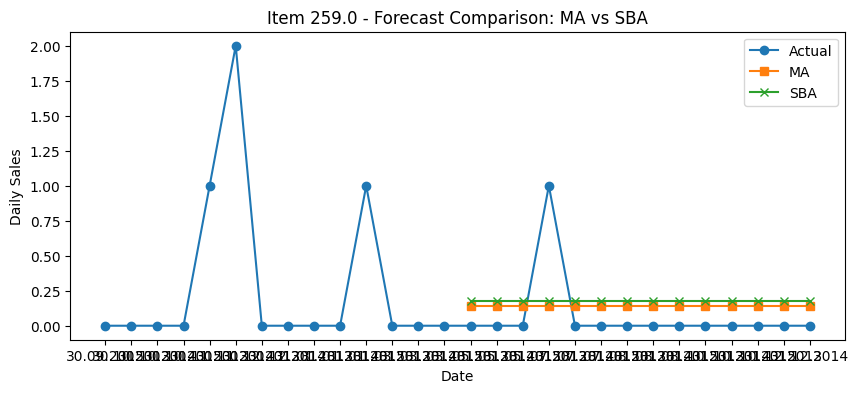

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Item 319.0 Metrics:
  MA   -> MAE: 0.000, MASE: 0.000
  SBA  -> MAE: 0.003, MASE: 1.407



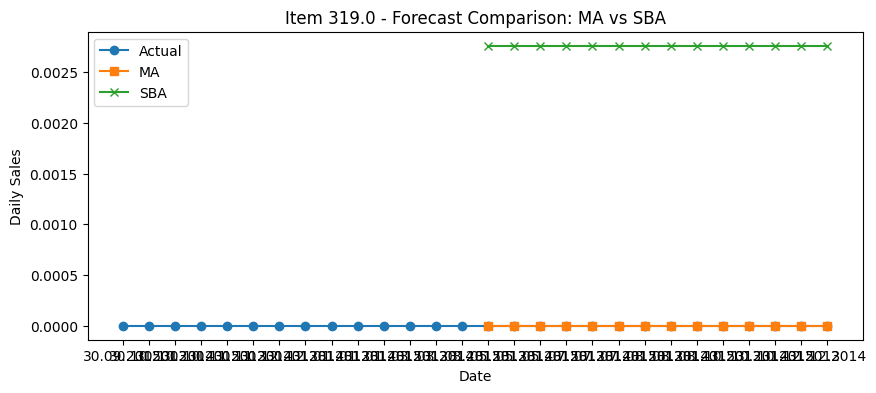

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Item 3189.0 Metrics:
  MA   -> MAE: 0.000, MASE: 0.000
  SBA  -> MAE: 0.006, MASE: 2.831



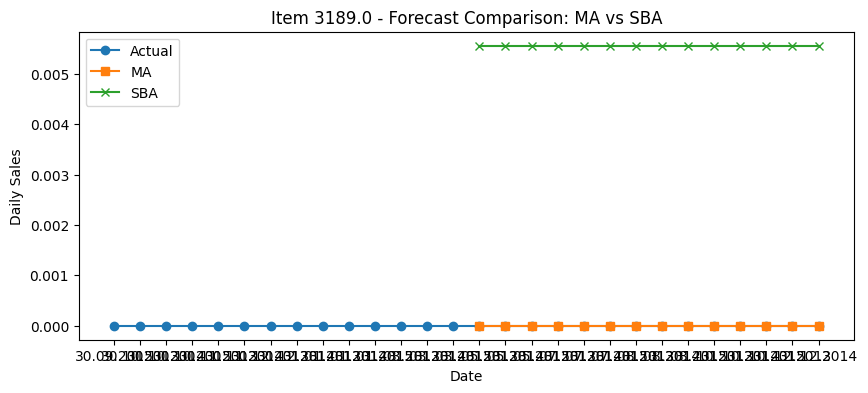

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Item 1776.0 Metrics:
  MA   -> MAE: 0.143, MASE: 1.373
  SBA  -> MAE: 0.188, MASE: 1.809



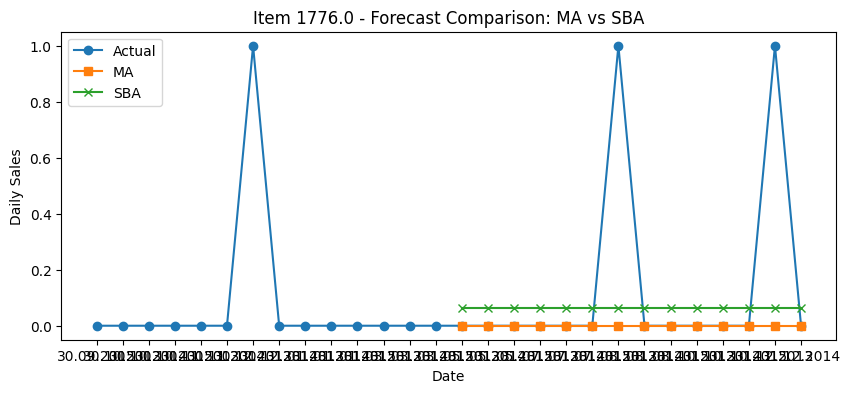

In [112]:
import matplotlib.pyplot as plt


sample_items = np.random.choice(intermittent_items, size=5, replace=False)
forecast_horizon = 14  # dự báo 2 tuần

for item_id in sample_items:
    series = daily_series_df.loc[item_id]
    train = series[:-forecast_horizon]
    test = series[-forecast_horizon:]
    
    # Forecast
    ma_forecast = moving_average(train, window=7, n_forecast=forecast_horizon)

    print(ma_forecast)
    sba_forecast = sba(train, alpha=0.1, n_forecast=forecast_horizon)
    
    # Metrics
    ma_mae = mean_absolute_error(test, ma_forecast)
    sba_mae = mean_absolute_error(test, sba_forecast)
    
    ma_mase = mase(test, ma_forecast, train)
    sba_mase = mase(test, sba_forecast, train)
    
    print(f"Item {item_id} Metrics:")
    print(f"  MA   -> MAE: {ma_mae:.3f}, MASE: {ma_mase:.3f}")
    print(f"  SBA  -> MAE: {sba_mae:.3f}, MASE: {sba_mase:.3f}\n")
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(series.index[-forecast_horizon*2:], series[-forecast_horizon*2:], label="Actual", marker='o')
    plt.plot(series.index[-forecast_horizon:], ma_forecast, label="MA", marker='s')
    plt.plot(series.index[-forecast_horizon:], sba_forecast, label="SBA", marker='x')
    plt.title(f"Item {item_id} - Forecast Comparison: MA vs SBA")
    plt.xlabel("Date")
    plt.ylabel("Daily Sales")
    plt.legend()
    plt.show()


In [113]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    path_converter("/data/raw/sales_train.csv"), parse_dates=["date"], dayfirst=True
)
demand_type_df = pd.read_csv(path_converter("/data/features/demand_type.csv"))
df = df[df["item_cnt_day"] >= 0].copy()

df = df.merge(demand_type_df[["item_id", "demand_type"]], on="item_id", how="left")
df = df[df["demand_type"] == 2]  # giữ loại demand = 2 (intermittent)

# ----- Sửa hàm SBA để chấp nhận cả ngày -----
def sba_predict(demand_series, date_series=None, alpha=0.15):
    """
    demand_series: mảng số lượng (arr-like)
    date_series: mảng ngày tương ứng (arr-like of datetimes) -- nếu có thì tính interval bằng ngày
    Trả về: (Z, P) -- Z: smoothed size, P: smoothed interval (đơn vị: ngày nếu date_series đc cung cấp)
    """
    d = np.array(demand_series, dtype=float)
    pos = np.where(d > 0)[0]  # vị trí trong mảng (0-based)

    if len(pos) < 2:
        return 999, 999  # không đủ dữ liệu để dự báo

    sizes = d[pos]  # kích thước bán tại các lần bán
    # tính interval giữa các lần bán
    if date_series is None:
        intervals = np.diff(pos)  # đơn vị: số bản ghi (không khuyến nghị nếu dữ liệu không daily-contiguous)
    else:
        dates = np.array(pd.to_datetime(date_series))
        sale_dates = dates[pos]
        # diff trả timedelta64, chuyển sang số ngày int
        intervals = np.diff(sale_dates).astype('timedelta64[D]').astype(int)

    Z = float(sizes[0])
    P = float(intervals[0])

    # smoothing (bắt đầu từ lần bán thứ 2)
    for i in range(1, len(sizes)):
        Z = alpha * sizes[i] + (1 - alpha) * Z
        P = alpha * intervals[i - 1] + (1 - alpha) * P

    return round(Z, 1), round(P, 1)


# ----- Tính sai số dự báo cho từng lần phát sinh (trừ lần cuối cùng) -----
errors = []

# test từng item (ở đây giữ slice giống bạn, đổi [:5000] nếu muốn chạy nhiều item)
for item in df["item_id"].unique()[:200]:
    temp = df[df["item_id"] == item].sort_values("date").reset_index(drop=True)
    if len(temp) < 10:
        continue

    # vị trí (0-based) của các lần bán thực tế trong temp
    pos_idx = np.where(temp["item_cnt_day"].values > 0)[0]

    if len(pos_idx) == 0:
        continue

    print(pos_idx)  # in các vị trí (position) thay vì in index label

    # in thông tin lần bán
    print(f"\nItem {item} – Tổng cộng {len(pos_idx)} lần bán:")
    for j, p in enumerate(pos_idx):
        date = temp.loc[p, "date"].date()
        qty = temp.loc[p, "item_cnt_day"]
        print(f"  Lần {j+1:2d}: Ngày {date} | Pos = {p:4d} | Bán = {qty} cái")

    # duyệt từng lần bán trừ lần cuối cùng
    for k in range(len(pos_idx) - 1):
        current_pos = pos_idx[k]
        next_pos = pos_idx[k + 1]

        # lịch sử tính đến lần bán hiện tại (bao gồm bản ghi lần bán hiện tại)
        history_counts = temp.loc[:current_pos, "item_cnt_day"].values
        history_dates = temp.loc[:current_pos, "date"].values  # numpy datetime64

        # dự báo chu kỳ tại thời điểm này (đơn vị ngày vì truyền date_series)
        _, predicted_interval = sba_predict(history_counts, history_dates, alpha=0.15)

        # thực tế: số ngày giữa hai lần bán
        actual_interval = (temp.loc[next_pos, "date"] - temp.loc[current_pos, "date"]).days

        errors.append({
            "item_id": item,
            "forecast_date": temp.loc[current_pos, "date"].date(),
            "actual_next_date": temp.loc[next_pos, "date"].date(),
            "predicted_interval": predicted_interval,
            "actual_interval": actual_interval,
            "error_days": actual_interval - predicted_interval,
            "abs_error_days": abs(actual_interval - predicted_interval)
        })

# kết quả
error_df = pd.DataFrame(errors)

if len(error_df) == 0:
    print("Không có lần dự báo nào được ghi nhận (error_df rỗng).")
else:
    MAE = error_df["abs_error_days"].mean()
    RMSE = np.sqrt((error_df["error_days"] ** 2).mean())
    accuracy_within_5_days = (error_df["abs_error_days"] <= 5).mean() * 100
    accuracy_within_10_days = (error_df["abs_error_days"] <= 10).mean() * 100

    print(f"Số lần dự báo: {len(error_df)}")
    print(f"MAE  = {MAE:.2f} ngày")
    print(f"RMSE = {RMSE:.2f} ngày")
    print(f"Đúng trong ±5 ngày : {accuracy_within_5_days:.2f}%")
    print(f"Đúng trong ±10 ngày: {accuracy_within_10_days:.2f}%")


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]

Item 2555 – Tổng cộng 56 lần bán:
  Lần  1: Ngày 2013-01-06 | Pos =    0 | Bán = 1.0 cái
  Lần  2: Ngày 2013-01-15 | Pos =    1 | Bán = 1.0 cái
  Lần  3: Ngày 2013-02-15 | Pos =    2 | Bán = 1.0 cái
  Lần  4: Ngày 2013-02-22 | Pos =    3 | Bán = 1.0 cái
  Lần  5: Ngày 2013-02-26 | Pos =    4 | Bán = 1.0 cái
  Lần  6: Ngày 2013-03-08 | Pos =    5 | Bán = 1.0 cái
  Lần  7: Ngày 2013-03-11 | Pos =    6 | Bán = 1.0 cái
  Lần  8: Ngày 2013-03-11 | Pos =    7 | Bán = 1.0 cái
  Lần  9: Ngày 2013-03-11 | Pos =    8 | Bán = 1.0 cái
  Lần 10: Ngày 2013-03-13 | Pos =    9 | Bán = 1.0 cái
  Lần 11: Ngày 2013-03-31 | Pos =   10 | Bán = 1.0 cái
  Lần 12: Ngày 2013-04-05 | Pos =   11 | Bán = 1.0 cái
  Lần 13: Ngày 2013-04-11 | Pos =   12 | Bán = 1.0 cái
  Lần 14: Ngày 2013-04-16 | Pos =   13 | Bán = 1.0 cái
  Lần 15: Ngày 2013-04-

In [114]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Giả sử bạn đã có:
# # df chứa các cột: predicted_interval, actual_interval, abs_error_days
# # và các giá trị:
# # MAE, RMSE, acc_5, acc_10

# # --- 1. Scatter Predicted vs Actual ---
# plt.figure(figsize=(8, 6))
# plt.scatter(df["predicted_interval"], df["actual_interval"], alpha=0.7, label="Dự đoán")
# plt.plot([df["actual_interval"].min(), df["actual_interval"].max()],
#          [df["actual_interval"].min(), df["actual_interval"].max()],
#          linestyle="--", label="Đường y=x (dự đoán lý tưởng)")

# plt.xlabel("Predicted Interval (days)")
# plt.ylabel("Actual Interval (days)")
# plt.title("Predicted vs Actual Intervals")
# plt.legend()
# plt.tight_layout()
# plt.show()


# # --- 2. Histogram phân bố sai số ---
# plt.figure(figsize=(8, 6))
# plt.hist(df["abs_error_days"], bins=15, edgecolor="black")
# plt.axvline(5, linestyle="--", label="±5 ngày", alpha=0.7)
# plt.axvline(10, linestyle="--", label="±10 ngày", alpha=0.7)

# plt.xlabel("Absolute Error (days)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Absolute Error")
# plt.legend()
# plt.tight_layout()
# plt.show()


# # --- 3. Bar chart các metric tổng quát ---
# metrics = ["MAE", "RMSE", "Acc ±5 ngày", "Acc ±10 ngày"]
# values = [MAE, RMSE, acc_5*100, acc_10*100]  # % chuyển sang %

# plt.figure(figsize=(8, 6))
# bars = plt.bar(metrics, values)
# plt.ylabel("Giá trị (days hoặc %)")
# plt.title("Overall Prediction Performance")

# # Ghi giá trị lên đầu cột
# for bar in bars:
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, height,
#              f"{height:.2f}", ha='center', va='bottom')

# plt.tight_layout()
# plt.show()
